Embeddings shape: (118, 1000)
PCA done. 15 components explain 72.0% variance


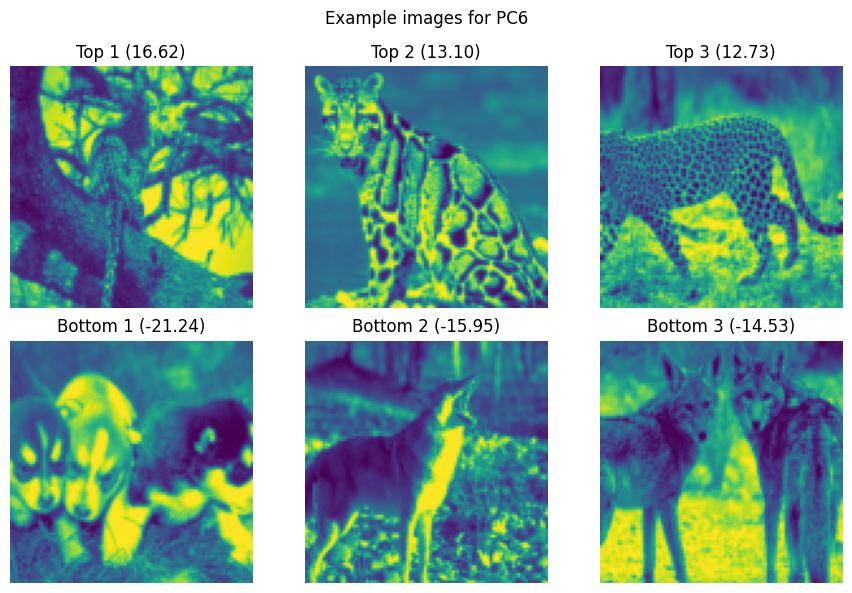

In [14]:
#!/usr/bin/env python3
"""
PCA visualization of ViT softmax+CLR embeddings:
 - U (image projections): histogram
 - V (class loadings): top ±10 ImageNet classes
 - Optional thumbnails of top-scoring images
"""

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr
from PIL import Image
import plotly.graph_objects as go

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
imgs_path = '/home/maria/MITNeuralComputation/vit_embeddings/images'
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
top_k = 10
n_components = 15

# ---------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------
with open(path, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']

# vit_arr is a numpy array (n_images × n_classes)
embeddings = np.asarray(vit_arr)
n_images = embeddings.shape[0]

# generate image IDs that match your files
image_ids = [f"scene_{i:03d}" for i in range(n_images)]

print("Embeddings shape:", embeddings.shape)
assert embeddings.ndim == 2

# Softmax → CLR
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

# ---------------------------------------------------------------
# PCA
# ---------------------------------------------------------------
pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_clr)
V = pca.components_.T  # shape: (n_classes, n_components)
expl_var = pca.explained_variance_ratio_

print(f"PCA done. {n_components} components explain {100*expl_var.sum():.1f}% variance")

# ---------------------------------------------------------------
# Helper to load ImageNet class names
# (You can replace this with your own list if needed)
try:
    from torchvision.models import vit_b_16, ViT_B_16_Weights
    class_names = ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]
except Exception:
    class_names = [f"class_{i}" for i in range(V.shape[0])]

# ---------------------------------------------------------------
# Function to plot top ±10 labels for one PC
# ---------------------------------------------------------------
def plot_pc_semantics_plotly(V, class_names, pc_idx, top_k=10):
    v = V[:, pc_idx]
    pos_idx = np.argsort(v)[-top_k:][::-1]
    neg_idx = np.argsort(v)[:top_k]
    pos_names = [class_names[i] for i in pos_idx]
    neg_names = [class_names[i] for i in neg_idx]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=v[pos_idx],
        y=pos_names,
        orientation='h',
        marker_color='green',
        name='Positive'
    ))
    fig.add_trace(go.Bar(
        x=v[neg_idx],
        y=neg_names,
        orientation='h',
        marker_color='red',
        name='Negative'
    ))
    fig.update_layout(
        title=f"PC{pc_idx+1} — top ±{top_k} ImageNet categories",
        barmode='overlay',
        xaxis_title="Loading weight",
        yaxis_title="Class",
        template="plotly_white"
    )
    return fig

# ---------------------------------------------------------------
# Function to show histogram of U[:, pc_idx]
# ---------------------------------------------------------------
def plot_pc_distribution_plotly(U, pc_idx):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=U[:, pc_idx],
        nbinsx=25,
        marker_color='steelblue'
    ))
    fig.update_layout(
        title=f"Distribution of image projections on PC{pc_idx+1}",
        xaxis_title="PC score",
        yaxis_title="Count",
        template="plotly_white"
    )
    return fig

# ---------------------------------------------------------------
# Example: visualize one PC
# ---------------------------------------------------------------
pc_idx = 5 # change 0..14 for others
fig_labels = plot_pc_semantics_plotly(V, class_names, pc_idx, top_k)
fig_images = plot_pc_distribution_plotly(U, pc_idx)

fig_labels.show()
fig_images.show()

# ---------------------------------------------------------------
# Optional: save top / bottom scoring images per PC
# ---------------------------------------------------------------
def show_top_images(U, pc_idx, image_ids, imgs_path, top_n=3):
    """Show top and bottom scoring images for a given PC."""
    scores = U[:, pc_idx]
    top_idx = np.argsort(scores)[-top_n:][::-1]
    bot_idx = np.argsort(scores)[:top_n]

    fig, axes = plt.subplots(2, top_n, figsize=(3*top_n, 6))

    for i, idx in enumerate(top_idx):
        # Add .png extension if not present
        img_name = image_ids[idx]
        if not img_name.endswith(".png"):
            img_name += ".png"
        img_path = os.path.join(imgs_path, img_name)

        if os.path.exists(img_path):
            axes[0, i].imshow(Image.open(img_path))
        axes[0, i].set_title(f"Top {i+1} ({scores[idx]:.2f})")
        axes[0, i].axis("off")

    for i, idx in enumerate(bot_idx):
        img_name = image_ids[idx]
        if not img_name.endswith(".png"):
            img_name += ".png"
        img_path = os.path.join(imgs_path, img_name)

        if os.path.exists(img_path):
            axes[1, i].imshow(Image.open(img_path))
        axes[1, i].set_title(f"Bottom {i+1} ({scores[idx]:.2f})")
        axes[1, i].axis("off")

    plt.suptitle(f"Example images for PC{pc_idx+1}")
    plt.tight_layout()
    plt.show()


# Uncomment if you have image files:
show_top_images(U, pc_idx, image_ids, imgs_path)


In [19]:
#!/usr/bin/env python3
"""
Full PCA interpretability atlas for ViT softmax+CLR embeddings.

For each PC:
 - Plotly bar chart (top ±10 ImageNet categories)
 - Matplotlib mosaic of top 10 and bottom 10 image thumbnails
 - Saves both to pca_panels/
"""

import os, pickle, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr
from PIL import Image
import plotly.graph_objects as go

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
imgs_path = '/home/maria/MITNeuralComputation/vit_embeddings/images'
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
top_k = 10
n_components = 20
out_dir = 'pca_panels'
os.makedirs(out_dir, exist_ok=True)

# ---------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------
with open(path, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']

embeddings = np.asarray(vit_arr)
n_images, n_classes = embeddings.shape
image_ids = [f"scene_{i:03d}" for i in range(n_images)]
print(f"Embeddings shape: {embeddings.shape}")

# ---------------------------------------------------------------
# TRANSFORM AND PCA
# ---------------------------------------------------------------
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

# First fit PCA with all components to measure variance explained
pca_full = PCA(n_components=min(X_clr.shape), random_state=0)
pca_full.fit(X_clr)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find smallest number of PCs covering ≥90% variance
n_components = np.searchsorted(cumulative_var, 0.90) + 1

print(f"Selecting {n_components} PCs to cover 90% of variance "
      f"({100*cumulative_var[n_components-1]:.2f}%)")

# Refit PCA with that number of components
pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_clr)
V = pca.components_.T
expl_var = pca.explained_variance_ratio_


# ---------------------------------------------------------------
# Load class names
# ---------------------------------------------------------------
try:
    from torchvision.models import vit_b_16, ViT_B_16_Weights
    class_names = ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]
except Exception:
    class_names = [f"class_{i}" for i in range(V.shape[0])]

# ---------------------------------------------------------------
# Plotly: bar chart of top ±10 classes
# ---------------------------------------------------------------
def plot_pc_semantics_plotly(V, class_names, pc_idx, top_k=10):
    v = V[:, pc_idx]
    pos_idx = np.argsort(v)[-top_k:][::-1]
    neg_idx = np.argsort(v)[:top_k]
    pos_names = [class_names[i] for i in pos_idx]
    neg_names = [class_names[i] for i in neg_idx]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=v[pos_idx], y=pos_names,
        orientation='h', marker_color='green', name='Positive'
    ))
    fig.add_trace(go.Bar(
        x=v[neg_idx], y=neg_names,
        orientation='h', marker_color='red', name='Negative'
    ))
    fig.update_layout(
        title=f"PC{pc_idx+1} — top ±{top_k} ImageNet categories",
        barmode='overlay',
        xaxis_title="Loading weight",
        yaxis_title="Class",
        template="plotly_white"
    )
    return fig

# ---------------------------------------------------------------
# Matplotlib: 10×2 image mosaic (top/bottom)
# ---------------------------------------------------------------
def save_top_images(U, pc_idx, image_ids, imgs_path, out_dir, top_n=10):
    scores = U[:, pc_idx]
    top_idx = np.argsort(scores)[-top_n:][::-1]
    bot_idx = np.argsort(scores)[:top_n]

    fig, axes = plt.subplots(2, top_n, figsize=(2.5*top_n, 5))
    for i, idx in enumerate(top_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[0, i].imshow(Image.open(img_path))
        axes[0, i].set_title(f"Top {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[0, i].axis("off")

    for i, idx in enumerate(bot_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[1, i].imshow(Image.open(img_path))
        axes[1, i].set_title(f"Bottom {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[1, i].axis("off")

    plt.suptitle(f"Example images for PC{pc_idx+1} ({expl_var[pc_idx]*100:.2f}% variance)", fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"PC{pc_idx+1:02d}_images.png")
    plt.savefig(out_path, dpi=150)
    plt.close(fig)

# ---------------------------------------------------------------
# MAIN LOOP
# ---------------------------------------------------------------
for pc_idx in range(n_components):
    print(f"Saving PC{pc_idx+1}/{n_components} ...")

    # Plotly bar chart
    fig = plot_pc_semantics_plotly(V, class_names, pc_idx, top_k=top_k)
    fig.write_html(os.path.join(out_dir, f"PC{pc_idx+1:02d}_bars.html"))

    # Image mosaic
    save_top_images(U, pc_idx, image_ids, imgs_path, out_dir, top_n=10)

print(f"\n✅ All {n_components} components saved in '{out_dir}/'")


Embeddings shape: (118, 1000)
Selecting 44 PCs to cover 90% of variance (90.31%)
Saving PC1/44 ...
Saving PC2/44 ...
Saving PC3/44 ...
Saving PC4/44 ...
Saving PC5/44 ...
Saving PC6/44 ...
Saving PC7/44 ...
Saving PC8/44 ...
Saving PC9/44 ...
Saving PC10/44 ...
Saving PC11/44 ...
Saving PC12/44 ...
Saving PC13/44 ...
Saving PC14/44 ...
Saving PC15/44 ...
Saving PC16/44 ...
Saving PC17/44 ...
Saving PC18/44 ...
Saving PC19/44 ...
Saving PC20/44 ...
Saving PC21/44 ...
Saving PC22/44 ...
Saving PC23/44 ...
Saving PC24/44 ...
Saving PC25/44 ...
Saving PC26/44 ...
Saving PC27/44 ...
Saving PC28/44 ...
Saving PC29/44 ...
Saving PC30/44 ...
Saving PC31/44 ...
Saving PC32/44 ...
Saving PC33/44 ...
Saving PC34/44 ...
Saving PC35/44 ...
Saving PC36/44 ...
Saving PC37/44 ...
Saving PC38/44 ...
Saving PC39/44 ...
Saving PC40/44 ...
Saving PC41/44 ...
Saving PC42/44 ...
Saving PC43/44 ...
Saving PC44/44 ...

✅ All 44 components saved in 'pca_panels/'


In [20]:
import os

out_dir = "pca_panels"
index_path = os.path.join(out_dir, "index.html")

# Collect all PCs (assuming PC01_bars.html and PC01_images.png pattern)
pcs = sorted(set(f.split("_")[0] for f in os.listdir(out_dir) if f.endswith("_bars.html")))

html_parts = [
    "<html><head>",
    "<meta charset='utf-8'/>",
    "<title>ViT PCA Atlas</title>",
    "<style>",
    "body { font-family: sans-serif; background-color: #f9f9f9; margin: 40px; }",
    "h2 { margin-top: 60px; }",
    "iframe { border: none; width: 100%; height: 500px; }",
    "img { width: 100%; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.2); }",
    ".panel { background: white; padding: 20px; border-radius: 10px; margin-bottom: 40px; box-shadow: 0 0 10px rgba(0,0,0,0.05); }",
    "</style></head><body>",
    "<h1>ViT PCA Interpretability Atlas</h1>",
    f"<p>Found {len(pcs)} principal components in <code>{out_dir}</code>.</p>"
]

for pc_prefix in pcs:
    num = pc_prefix.replace("PC", "")
    bar_html = f"{pc_prefix}_bars.html"
    img_png = f"{pc_prefix}_images.png"

    html_parts.append("<div class='panel'>")
    html_parts.append(f"<h2>Principal Component {int(num)}</h2>")
    if os.path.exists(os.path.join(out_dir, bar_html)):
        html_parts.append(f"<iframe src='{bar_html}'></iframe>")
    if os.path.exists(os.path.join(out_dir, img_png)):
        html_parts.append(f"<img src='{img_png}' alt='PC{num} images'/>")
    html_parts.append("</div>")

html_parts.append("</body></html>")

# Write file
with open(index_path, "w") as f:
    f.write("\n".join(html_parts))

print(f"✅ HTML index created: {index_path}")


✅ HTML index created: pca_panels/index.html
